<h3>Does precipitation level has anything to do with accident count?</h3>

`US_Accidents_Dec21_updated.csv` and `WeatherEvents_Jan2016-Dec2021.csv` are the main data.<br>
`US_Accidents_Dec21_updated.csv` - accident records for all the states.<br>
`WeatherEvents_Jan2016-Dec2021.csv` - weather events for all the states.<br><br>

Data of 5 cities from different states are extracted and combined.<br>
Producing 5 tables, `[City].csv`, which has **date** (2016-01-01 -> 2021-12-31) as row.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [6]:
names = ["Denver", "Miami", "Minneapolis", "New York", "Phoenix"]
category = ['W0000_0600','W0601_1200','W1201_1800','W1801_2359','WS1','WS2','WS3','WS4','AS0000_0600','AS0601_1200','AS1201_1800','AS1801_2359','Accident']
city_count = len(names)
cities = [ 
 pd.read_csv(names[0] + '.csv')
,pd.read_csv(names[1] + '.csv')
,pd.read_csv(names[2] + '.csv')
,pd.read_csv(names[3] + '.csv')
,pd.read_csv(names[4] + '.csv')
]
cities_cat = []
for i in range(city_count):
	cities_cat.append(cities[i][category].astype('category'))

In [7]:
cities_cat[0].describe()

,W0000_0600,W0601_1200,W1201_1800,W1801_2359,WS1,WS2,WS3,WS4,AS0000_0600,AS0601_1200,AS1201_1800,AS1801_2359,Accident
count,2192,2192,2192,2192,506,342,344,408,2192,2192,2192,2192,2192
unique,7,6,6,6,5,4,4,5,5,5,5,5,2
top,Clear,Clear,Clear,Clear,Light,Light,Light,Light,0,0,0,0,True
freq,1686,1850,1848,1784,394,236,156,304,1244,1165,1495,1929,1476


In [8]:
print("Weather type: ", cities_cat[0]['W0000_0600'].unique(), end ='\n\n')
print("Weather severity: ", cities_cat[0]['WS1'].unique(), end ='\n\n')
print("Accident severity: ", cities_cat[0]['AS0000_0600'].unique())
print("Dimension: ", cities[0].shape[0], "x", cities[0].shape[1])

Weather type:  ['Clear', 'Snow', 'Fog', 'Storm', 'Rain', 'Precipitation', 'Cold']
Categories (7, object): ['Clear', 'Cold', 'Fog', 'Precipitation', 'Rain', 'Snow', 'Storm']

Weather severity:  [NaN, 'Light', 'Moderate', 'Severe', 'UNK', 'Heavy']
Categories (5, object): ['Heavy', 'Light', 'Moderate', 'Severe', 'UNK']

Accident severity:  [0, 2, 3, 4, 1]
Categories (5, int64): [0, 1, 2, 3, 4]
Dimension:  2192 x 16


In [ ]:
cities[0].corr() # this is just for the first city

,AS0000_0600,AS0601_1200,AS1201_1800,AS1801_2359,P_Value(in),A_Total,Accident
AS0000_0600,1.000000,0.419955,0.281306,0.074568,0.007494,0.472691,0.578661
AS0601_1200,0.419955,1.000000,0.342712,0.096925,-0.011970,0.480028,0.622771
AS1201_1800,0.281306,0.342712,1.000000,0.129609,-0.013796,0.479828,0.455465
AS1801_2359,0.074568,0.096925,0.129609,1.000000,0.000089,0.171389,0.247256
P_Value(in),0.007494,-0.011970,-0.013796,0.000089,1.000000,-0.005981,-0.046722
A_Total,0.472691,0.480028,0.479828,0.171389,-0.005981,1.000000,0.476280
Accident,0.578661,0.622771,0.455465,0.247256,-0.046722,0.476280,1.000000


Types of analysis:
   1. Correlation Matrix / Heatmap [ sb.heatmap(jointDF.corr(), vmin = -1, vmax = 1, annot = True, fmt=".2f") ]
   2. No. of Weathers that occur from 2016 to 2021
   3. Uni-Variate Linear Regression (Predictor = precipitation)
   4. Goodness of Fit of the Model
   5. Regression with random train-test split
   6. Simple Decision tree (Response = Accident[T/F], Predictor = precipitation) [done in 
   7. Classification tree with Random Train-Test Split [done] 
   8. Prediction of Accident [can be done after finalising the rest]

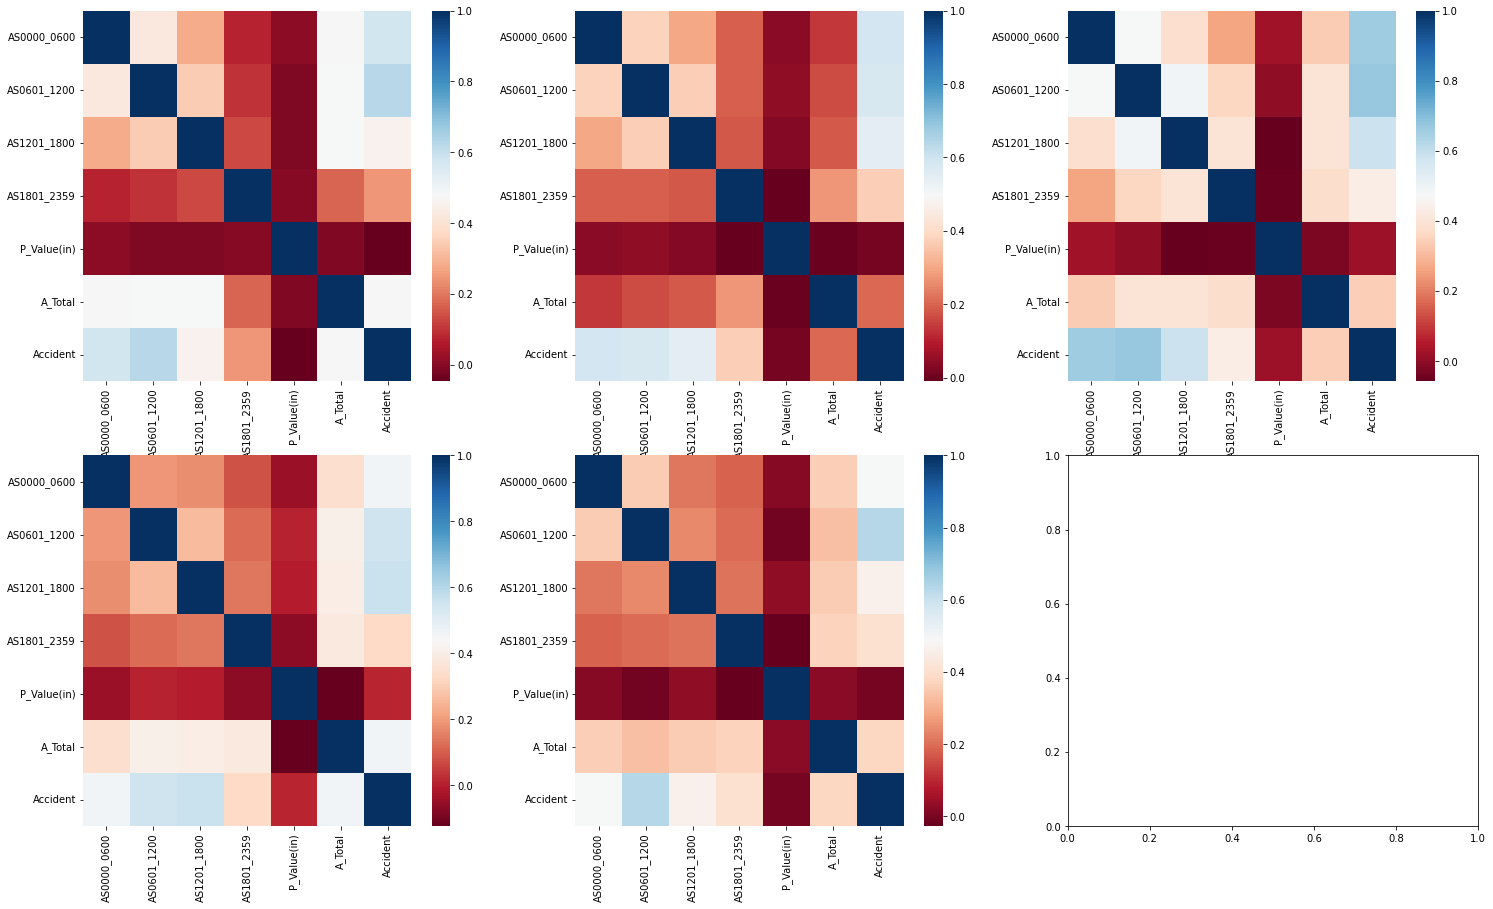

In [9]:
f, axes = plt.subplots(2, 3, figsize=(25, 15))

for i in range(5):  # correlation for all city
	sb.heatmap(cities[i].corr(), ax = axes[int(i/3),i%3], cmap = "RdBu")

It seems to be have no relationship between preciptation level and accident count.

<h3>Weather type vs Accident count</h3>

Row order: 1. Denver 2. Miami 3. Minneapolis 4. New York 5. Phoenix

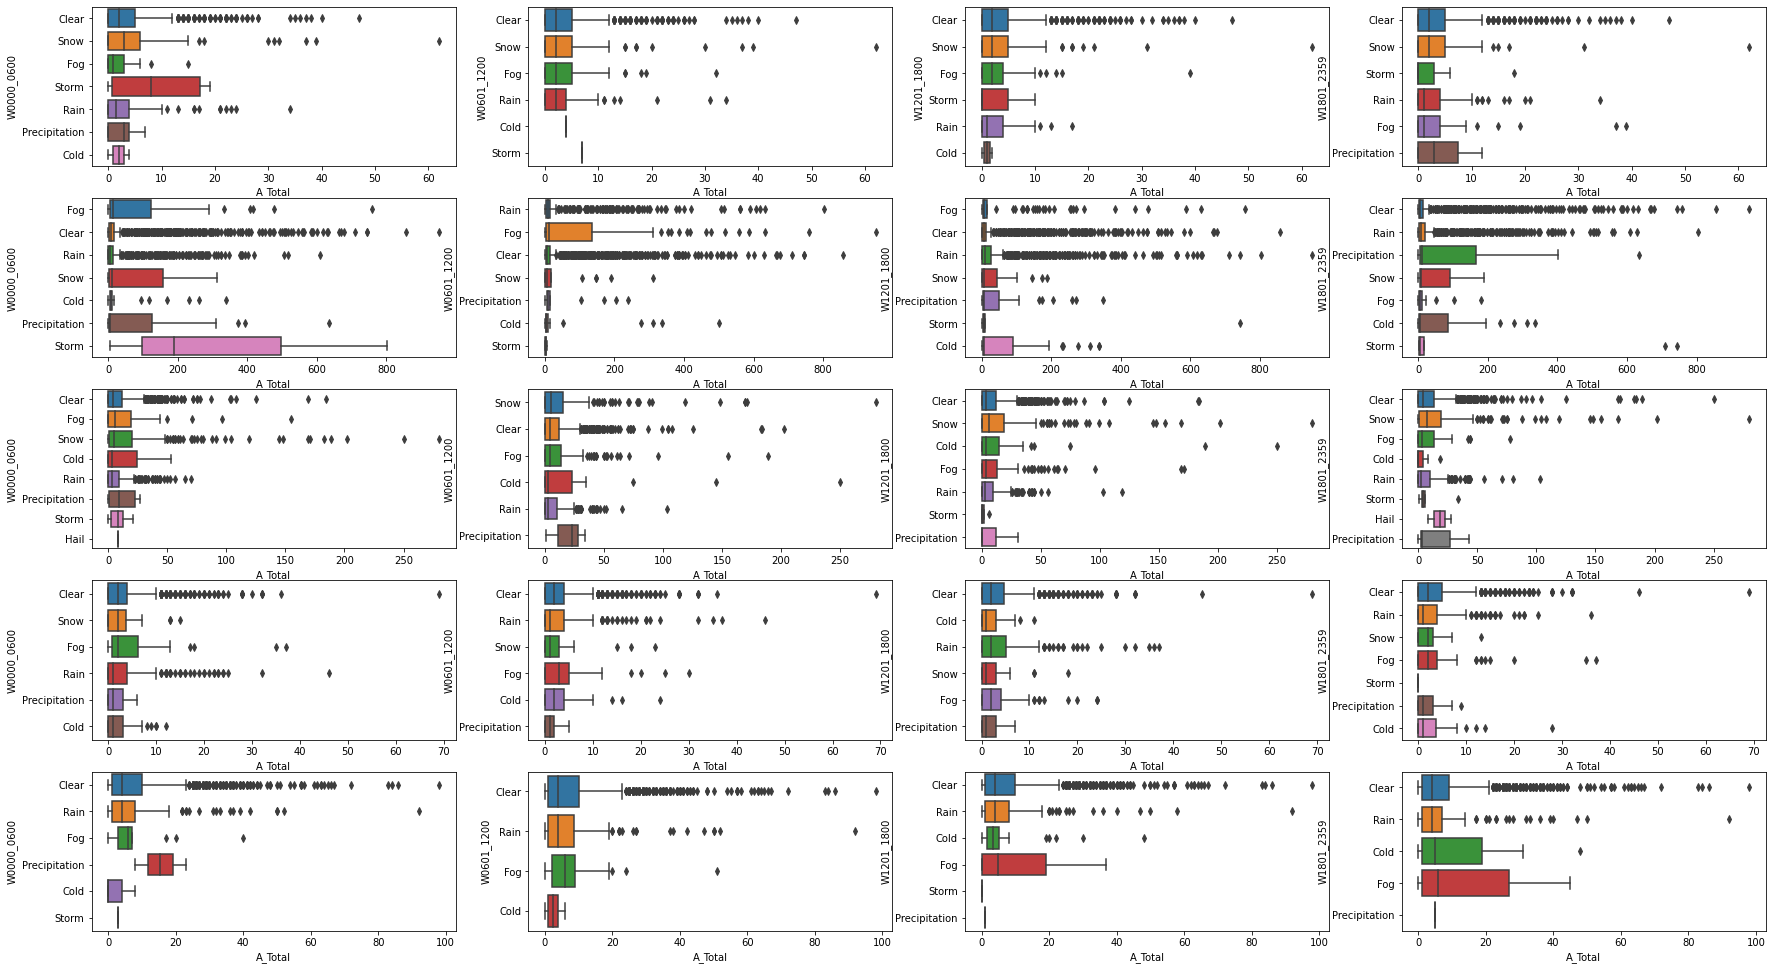

In [11]:
f, axes = plt.subplots(5, 4, figsize=(30, 17))
for i in range(city_count):
	for j in range(4):
		sb.boxplot(x = 'A_Total', y = category[j] , data = cities[i], orient = 'h', ax = axes[i,j])

<h3>Weather serverity vs Accident count</h3>

Row order: 1. Denver 2. Miami 3. Minneapolis 4. New York 5. Phoenix

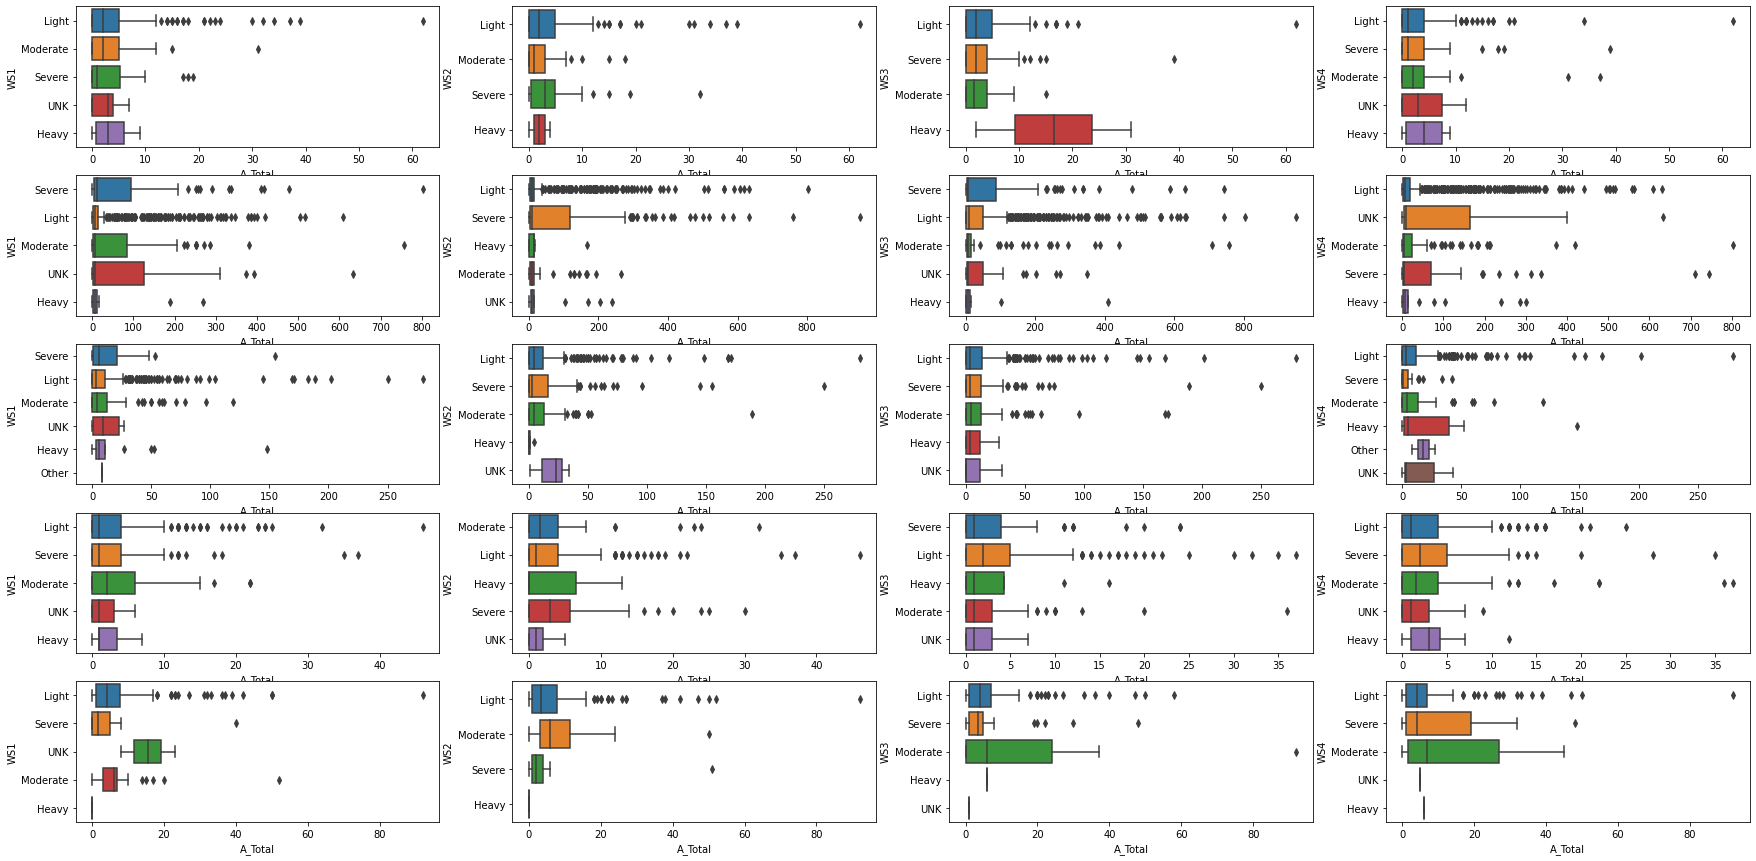

In [12]:
f, axes = plt.subplots(5, 4, figsize=(30, 15))
for i in range(city_count):
	for j in range(4):
		sb.boxplot(x = 'A_Total', y = category[j + 4] , data = cities[i], orient = 'h', ax = axes[i,j])

<h3>Getting week summary of weather events and accident count</h3>

New tables will be generated and stored in `cities_week`<br>
Columns will be `weather types` and `A_total (in week)`<br>

In [51]:
row_init = cities[0].shape[0]
row_count = int(row_init / 7)
type_str = cities[0]['W0000_0600'].unique()
type_count = len(type_str)
col_order = type_str.tolist()

col_order.append("Events")
col_order.append("A_Total")
col_order.append("P_Value(in)")
cities_week = [[]] * city_count
for i in range(city_count):
	cities_week[i] = [[]] * row_count

print("Col order:", col_order)
# this part requires some time to sum up the records every 7 days
for i in range(city_count):
	accumulate = [0 for i in range(type_count + 3)]
	for j in range(row_init):
		if j%7 == 0 and j != 0:
			for k in range(1, type_count):
				accumulate[type_count] = accumulate[type_count] + accumulate[k]
			cities_week[i][int(j/7)-1] = accumulate
			accumulate = [0 for i in range(type_count + 3)]
		for k in range(type_count):
			for c in range(4): # category 0, 1, 2, 3
				if cities[i][category[c]][j] == type_str[k]:
					accumulate[k] = accumulate[k] + 1
		accumulate[type_count + 1] = accumulate[type_count + 1] + cities[i]['A_Total'][j]
		accumulate[type_count + 2] = accumulate[type_count + 2] + cities[i]['P_Value(in)'][j]

print("Captured: ", len(cities_week), "cities,", len(cities_week[0]), "rows,", len(cities_week[0][312]), "columns")
for i in range(city_count):
	cities_week[i] = pd.DataFrame.from_records(cities_week[i], columns=col_order)


Col order: ['Clear', 'Snow', 'Fog', 'Storm', 'Rain', 'Precipitation', 'Cold', 'Events', 'A_Total', 'P_Value(in)']
Captured:  5 cities, 313 rows, 10 columns


In [52]:
cities_week[0].head(2) # summary of first 7 days from cities[0]

,Clear,Snow,Fog,Storm,Rain,Precipitation,Cold,Events,A_Total,P_Value(in)
0,25,3,0,0,0,0,0,3,0,0.39
1,20,6,2,0,0,0,0,8,0,0.31


In [53]:
cities[0].head(14) # calculate the amount of 'Clear' and 'Snow' and compare it with the out put of previous cells

,Date,W0000_0600,W0601_1200,W1201_1800,W1801_2359,WS1,WS2,WS3,WS4,AS0000_0600,AS0601_1200,AS1201_1800,AS1801_2359,P_Value(in),A_Total,Accident
0,1/1/2016,Clear,Clear,Clear,Clear,NaN,NaN,NaN,NaN,0,0,0,0,0.00,0,False
1,1/2/2016,Clear,Clear,Clear,Clear,NaN,NaN,NaN,NaN,0,0,0,0,0.00,0,False
2,1/3/2016,Clear,Clear,Clear,Clear,NaN,NaN,NaN,NaN,0,0,0,0,0.00,0,False
3,1/4/2016,Clear,Clear,Clear,Clear,NaN,NaN,NaN,NaN,0,0,0,0,0.00,0,False
4,1/5/2016,Clear,Clear,Clear,Clear,NaN,NaN,NaN,NaN,0,0,0,0,0.00,0,False
5,1/6/2016,Clear,Clear,Clear,Clear,NaN,NaN,NaN,NaN,0,0,0,0,0.00,0,False
6,1/7/2016,Clear,Snow,Snow,Snow,NaN,Light,Light,Light,0,0,0,0,0.39,0,False
7,1/8/2016,Clear,Snow,Snow,Snow,NaN,Moderate,Light,Light,0,0,0,0,0.30,0,False
8,1/9/2016,Snow,Clear,Clear,Snow,Light,NaN,NaN,Light,0,0,0,0,0.01,0,False
9,1/10/2016,Clear,Fog,Snow,Clear,NaN,Severe,Light,NaN,0,0,0,0,0.00,0,False


In [38]:
cities_week[1].corr() # unfortunately, there are still no relations between weather and accident count

,Clear,Snow,Fog,Storm,Rain,Precipitation,Cold,Events,A_total,P_Value(in)
Clear,1.000000,-0.010711,-0.070770,0.032004,-0.896279,-0.249017,-0.153613,-1.000000,-0.072154,-0.522621
Snow,-0.010711,1.000000,0.123985,-0.046715,-0.149684,-0.091996,-0.104073,0.010711,0.017030,-0.107933
Fog,-0.070770,0.123985,1.000000,-0.010263,-0.249914,-0.035288,-0.082596,0.070770,0.192506,-0.184582
Storm,0.032004,-0.046715,-0.010263,1.000000,-0.094803,-0.091111,0.126901,-0.032004,0.160381,-0.103301
Rain,-0.896279,-0.149684,-0.249914,-0.094803,1.000000,0.131329,-0.058250,0.896279,-0.038443,0.540507
Precipitation,-0.249017,-0.091996,-0.035288,-0.091111,0.131329,1.000000,-0.036734,0.249017,0.126519,0.461952
Cold,-0.153613,-0.104073,-0.082596,0.126901,-0.058250,-0.036734,1.000000,0.153613,0.061471,-0.032318
Events,-1.000000,0.010711,0.070770,-0.032004,0.896279,0.249017,0.153613,1.000000,0.072154,0.522621
A_total,-0.072154,0.017030,0.192506,0.160381,-0.038443,0.126519,0.061471,0.072154,1.000000,-0.046126
P_Value(in),-0.522621,-0.107933,-0.184582,-0.103301,0.540507,0.461952,-0.032318,0.522621,-0.046126,1.000000


In [54]:
for i in range(city_count): # for each cities
	print(cities_week[i][['Events', 'P_Value(in)']].corr())

               Events  P_Value(in)
Events       1.000000     0.523511
P_Value(in)  0.523511     1.000000
               Events  P_Value(in)
Events       1.000000     0.522621
P_Value(in)  0.522621     1.000000
               Events  P_Value(in)
Events       1.000000     0.180108
P_Value(in)  0.180108     1.000000
               Events  P_Value(in)
Events       1.000000     0.672076
P_Value(in)  0.672076     1.000000
               Events  P_Value(in)
Events       1.000000     0.599297
P_Value(in)  0.599297     1.000000


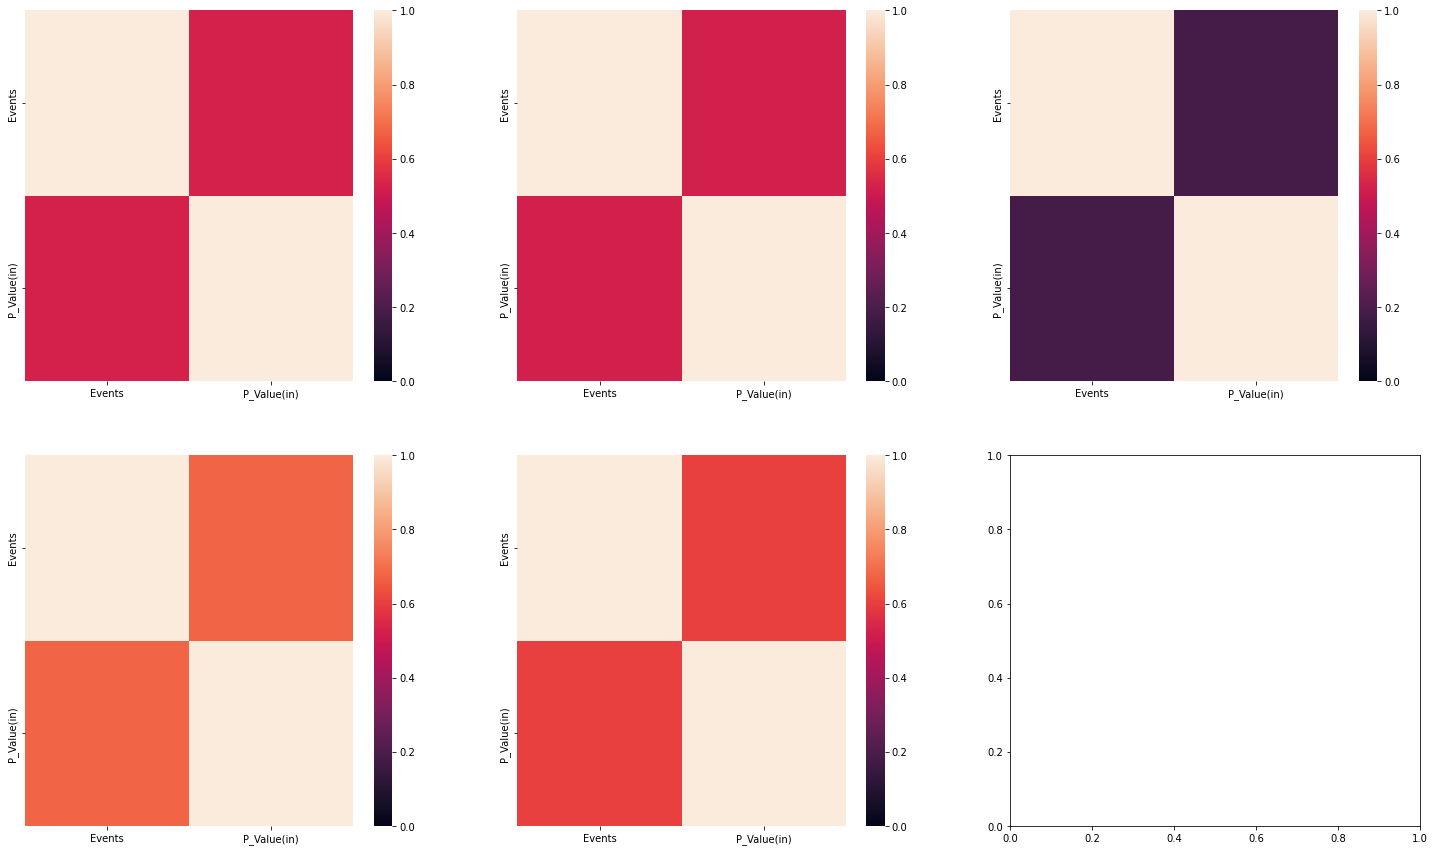

In [55]:
f, axes = plt.subplots(2, 3, figsize=(25, 15)) # relations between weather count and for all cities

for i in range(city_count):
	sb.heatmap(cities_week[i][['Events', 'P_Value(in)']].corr(), ax = axes[int(i/3),i%3], vmin=0, vmax=1)

In [96]:
# join plot between weather events and accident count in week for all cities
data = pd.concat([cities_week[0], cities_week[1], cities_week[2], cities_week[3], cities_week[4]],axis=0, ignore_index=True)
data.head()

,Clear,Snow,Fog,Storm,Rain,Precipitation,Cold,Events,A_Total,P_Value(in)
0,25,3,0,0,0,0,0,3,0,0.39
1,20,6,2,0,0,0,0,8,0,0.31
2,23,4,1,0,0,0,0,5,0,0.05
3,26,2,0,0,0,0,0,2,0,0.00
4,18,10,0,0,0,0,0,10,0,0.92


<h3>Classifcation Tree to predict whether weather cause accident</h3>

Row order:
1. Denver
2. Miami
3. Minneapolis
4. New York
5. Phoenix

# CODE DUMP BELOW

In [ ]:
wth = [[0]*4]*5
for i in range(city_count):
	for j in range(4):
		wth[i][j] = pd.DataFrame(cities[i][category[j]])


#  Changing the values of Accident Severity to True and false (0 = F, >0 = T)
accdnt = [[0]*4]*5
for i in range(city_count):
	for j in range(4):
		accdnt[i][j] = pd.DataFrame(cities[i][category[j+8]])
		accdnt[i][j] = accdnt[i][j].replace({0: False, 1: True, 2: True, 3: True, 4: True, 5: True})

feature_col = [['W0000_0600_Clear', 'W0000_0600_Cold', 'W0000_0600_Fog', 'W0000_0600_Rain', 'W0000_0600_Snow', 'W0000_0600_Storm'], ['W0601_1200_Clear', 'W0601_1200_Cold', 'W0601_1200_Fog', 'W0601_1200_Rain', 'W0601_1200_Snow', 'W0601_1200_Storm'], ['W1201_1800_Clear', 'W01201_1800_Cold', 'W1201_1800_Fog', 'W1201_1800_Rain', 'W1201_1800_Snow', 'W1201_1800_Storm'], ['W1801_2359_Clear', 'W01801_2359_Cold', 'W1801_2359_Fog', 'W1801_2359_Rain', 'W1801_2359_Snow', 'W1801_2359_Storm']]


odata = [[0]*4]*5
for i in range(city_count):
	for j in range(4):
		odata[i][j] = pd.get_dummies(wth[i][j])

#print(odata)   [dont have snow data why?]

dict = {'W0000_0600_Clear': 'Clear', 'W0601_1200_Clear':'Clear', 'W1201_1800_Clear':'Clear', 'W1801_2359_Clear':'Clear',
        'W0000_0600_Rain': 'Rain', 'W0601_1200_Rain':'Rain', 'W1201_1800_Rain':'Rain', 'W1801_2359_Rain':'Rain',
        'W0000_0600_Fog': 'Fog', 'W0601_1200_Fog':'Fog', 'W1201_1800_Fog':'Fog', 'W1801_2359_Fog':'Fog',
        'W0000_0600_Snow': 'Snow', 'W0601_1200_Snow':'Snow', 'W1201_1800_Snow':'Snow', 'W1801_2359_Snow':'Snow',
        'W0000_0600_Storm': 'Storm', 'W0601_1200_Storm':'Storm', 'W1201_1800_Storm':'Storm', 'W1801_2359_Storm':'Storm',
        'W0000_0600_Cold': 'Cold', 'W0601_1200_Cold':'Cold', 'W1201_1800_Cold':'Cold', 'W1801_2359_Cold':'Cold',}
 
# call rename () method
for i in range(city_count):
	for j in range(4):
		odata[i][j].rename(columns=dict,inplace=True)

# Isolating each cities' weather into a dataset (do we want to remove Cold weather? what is it anyway? ><)
#weather_cat = ['Clear', 'Rain', 'Fog', 'Snow', 'Storm', 'Cold']

weather_D = odata[0][0].append(odata[0][1], ignore_index = True)
weather_MM = odata[1][0].append(odata[1][1], ignore_index = True)
weather_MP = odata[2][0].append(odata[2][1], ignore_index = True)
weather_NY = odata[3][0].append(odata[3][1], ignore_index = True)
weather_P = odata[4][0].append(odata[4][1], ignore_index = True)
# 1s and 0s for the weather data in each cities
for j in range(2):
	weather_D = weather_D.append(odata[0][j+2], ignore_index = True)
	weather_MM = weather_MM.append(odata[1][j+2], ignore_index = True)
	weather_MP = weather_MP.append(odata[2][j+2], ignore_index = True)
	weather_NY = weather_NY.append(odata[3][j+2], ignore_index = True)
	weather_P = weather_P.append(odata[4][j+2], ignore_index = True)

Things to do: 
1. append the P_value for each of the cities, along with the AS timings(T/F)
2. Implement the classification tree onto it

In [ ]:
cities[0]['P_Value(in)']